<font size=5><center>国际金融作业</center></font>

根据论文中的算法3生成一条全经济的跨度为30年的违约路径（未分级）：

In [1]:
import numpy as np
year = 30
t_range = year*365      # 考虑的时间跨度
c, k, sigma, gamma = 0.254, 0.004, 0.419, 0.810    # 参考论文取值
lam_0 = 8.709
lam_S = lam_0
lam_Tn = lam_0
S = 0
defau_eco = []         # 全经济范围内的违约路径

while True:     # 根据算法3生成全经济违约路径
    eps = np.random.exponential(scale=lam_S, size=1)[0]
    T = S + eps
    if T >= t_range:
        break
    lam_T = c*lam_Tn + (lam_S-c*lam_Tn)*np.exp(-k*lam_Tn*(T-S))
    u = np.random.normal(loc=0, scale=1)
    if u <= lam_T/lam_S:
        lam_T += max([gamma, sigma*lam_T])
        defau_eco.append(T)
        lam_Tn = lam_T
    S = T
    lam_S = lam_T

所得到的defau_eco即为全经济违约路径。违约路径是违约时间所组成的列表。之后生成分信用等级的全经济违约路径，为简化处理，我们假设有4个等级，当一个违约出现时，发生在4个等级中的概率分别为0.1, 0.2, 0.3, 0.4：

In [2]:
p1, p2, p3, p4 = 0.1, 0.2, 0.3, 0.4       # 各评级违约概率
defau_eco_1, defau_eco_2, defau_eco_3, defau_eco_4 = [], [], [], []

for d in defau_eco:     # 生成各评级违约路径
    u = np.random.uniform(0, 1)
    if u <= p1:
        defau_eco_1.append(d)
    elif p1 < u and u <= p1+p2:
        defau_eco_2.append(d)
    elif u > p1+p2+p3:
        defau_eco_4.append(d)
    else:
        defau_eco_3.append(d)

defau_eco_rank = [defau_eco_1, defau_eco_2, defau_eco_3, defau_eco_4]

接下来进行重抽样过程，首先对全经济与portfolio中各评级的债券数进行了一个预先的设定：

In [3]:
alpha = 0.5         # 参考论文取值
X_0 = [30, 40, 50, 30]      # portfolio中含有的各评级债券数
X_0_eco = [2000, 3000, 3000, 2000]      # 经济体中含有的各评级债券数

num = 1000          # 重复抽样次数

接下来根据算法1进行I=1K次的重抽样，vt来源于论文中的(4)式，Zt来源于论文中的(3)式：

In [4]:
defau_port = []      # 重复生成portfolio违约路径
for i in range(num):      # 重复重抽样
    d =[]
    for t in defau_eco:
        vt_1 = (len([x for x in defau_eco_1 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_2 = (len([x for x in defau_eco_2 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_3 = (len([x for x in defau_eco_3 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_4 = (len([x for x in defau_eco_4 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)

        vt = [vt_1, vt_2, vt_3, vt_4]

        Zt = 0
        for i in range(4):
            Zt += X_0[i]/(X_0_eco[i]-len([x for x in defau_eco_rank[i] if x<t]))*vt[i]

        u = np.random.uniform(0, 1)
        if u <= Zt:
            d.append(t)

    defau_port.append(d)
    # 注意defau_port中的每一个元素都是一条路径

defau_port即为所得到的1K条模拟的portfolio违约路径，是不分等级的。接下来是对违约路径进行一些处理，得到每一年的违约率。

In [5]:
def get_by_year(d_path):
    d = [0 for i in range(year)]
    for t in d_path:
        i = int(t//365)
        d[i] += 1
    return d
eco_d_rate = [n/sum(X_0_eco)*100 for n in get_by_year(defau_eco)]

port_d_num = np.array([get_by_year(d) for d in defau_port])
port_d_rate = [np.mean(port_d_num[:, i])/sum(X_0)*100 for i in range(year)]

eco_d_rate是全经济在30年内的违约率，port_d_rate是模拟的1K次portfolio违约路径30年内每年违约率的均值。分别对两组数据进行作图：

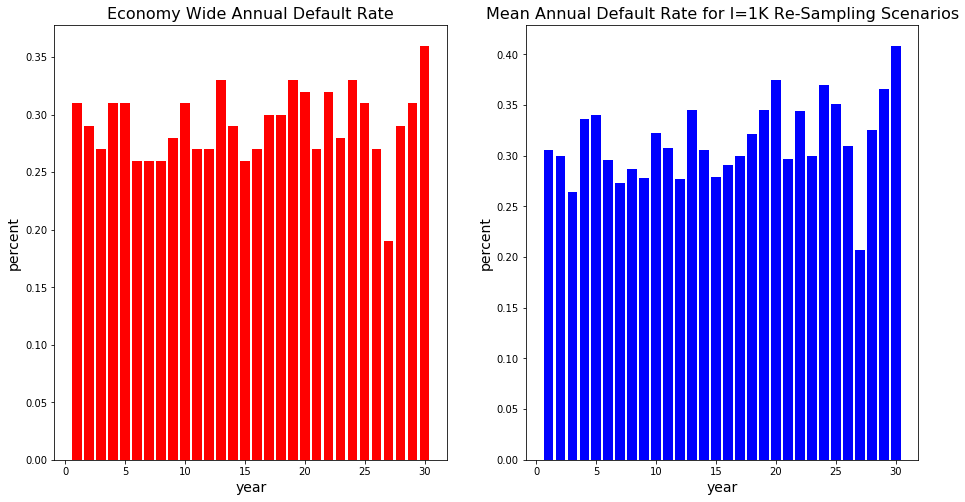

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(left=0.1, right=0.9)
plt.bar(range(1, year+1), eco_d_rate, fc='r')
plt.ylabel('percent', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.title('Economy Wide Annual Default Rate', fontsize=16)
plt.subplot(1, 2, 2)
plt.bar(range(1, year+1), port_d_rate, fc='b')
plt.ylabel('percent', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.title('Mean Annual Default Rate for I=1K Re-Sampling Scenarios', fontsize=16)
plt.show()

所得到的图形对应于论文中的figure1，左图为全经济违约率，右图为重抽样违约率的均值。

最后是所有代码的整合：

In [ ]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

year = 30
t_range = year*365      # 考虑的时间跨度
c, k, sigma, gamma = 0.254, 0.004, 0.419, 0.810    # 参考论文取值
lam_0 = 8.709
lam_S = lam_0
lam_Tn = lam_0
S = 0
defau_eco = []         # 全经济范围内的违约路径


while True:     # 根据算法3生成全经济违约路径
    eps = np.random.exponential(scale=lam_S, size=1)[0]
    T = S + eps
    if T >= t_range:
        break
    lam_T = c*lam_Tn + (lam_S-c*lam_Tn)*np.exp(-k*lam_Tn*(T-S))
    u = np.random.normal(loc=0, scale=1)
    if u <= lam_T/lam_S:
        lam_T += max([gamma, sigma*lam_T])
        defau_eco.append(T)
        lam_Tn = lam_T
    S = T
    lam_S = lam_T


p1, p2, p3, p4 = 0.1, 0.2, 0.3, 0.4       # 各评级违约概率
defau_eco_1, defau_eco_2, defau_eco_3, defau_eco_4 = [], [], [], []

for d in defau_eco:     # 生成各评级违约路径
    u = np.random.uniform(0, 1)
    if u <= p1:
        defau_eco_1.append(d)
    elif p1 < u and u <= p1+p2:
        defau_eco_2.append(d)
    elif u > p1+p2+p3:
        defau_eco_4.append(d)
    else:
        defau_eco_3.append(d)

defau_eco_rank = [defau_eco_1, defau_eco_2, defau_eco_3, defau_eco_4]


alpha = 0.5         # 参考论文取值
X_0 = [30, 40, 50, 30]      # portfolio中含有的各评级债券数
X_0_eco = [2000, 3000, 3000, 2000]      # 经济体中含有的各评级债券数

num = 1000          # 重复抽样次数


defau_port = []      # 重复生成portfolio违约路径
for i in range(num):      # 重复重抽样
    d =[]
    for t in defau_eco:
        vt_1 = (len([x for x in defau_eco_1 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_2 = (len([x for x in defau_eco_2 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_3 = (len([x for x in defau_eco_3 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)
        vt_4 = (len([x for x in defau_eco_4 if x<t]) + alpha) / 
                (len([x for x in defau_eco if x<t]) + alpha*4)

        vt = [vt_1, vt_2, vt_3, vt_4]

        Zt = 0
        for i in range(4):
            Zt += X_0[i]/(X_0_eco[i]-len([x for x in defau_eco_rank[i] if x<t]))*vt[i]

        u = np.random.uniform(0, 1)
        if u <= Zt:
            d.append(t)

    defau_port.append(d)
    # 注意defau_port中的每一个元素都是一条路径

def get_by_year(d_path):
    d = [0 for i in range(year)]
    for t in d_path:
        i = int(t//365)
        d[i] += 1
    return d

eco_d_rate = [n/sum(X_0_eco)*100 for n in get_by_year(defau_eco)]

port_d_num = np.array([get_by_year(d) for d in defau_port])
port_d_rate = [np.mean(port_d_num[:, i])/sum(X_0)*100 for i in range(year)]


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.subplots_adjust(left=0.1, right=0.9)
plt.bar(range(1, year+1), eco_d_rate, fc='r')
plt.ylabel('percent', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.title('Economy Wide Annual Default Rate', fontsize=16)
plt.subplot(1, 2, 2)
plt.bar(range(1, year+1), port_d_rate, fc='b')
plt.ylabel('percent', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.title('Mean Annual Default Rate for I=1K Re-Sampling Scenarios', fontsize=16)
plt.show()
